# Customer Transaction Analysis

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from pycaret.time_series import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('default')
%matplotlib inline 

In [4]:
def process_blank_rows(east):
    blank_rows = east[east['Order ID'].isnull()].index
    east.drop(index=blank_rows, inplace=True)
    return east

In [5]:
def process_null_values(east):
    east['Postal Code'].fillna(5401, inplace=True)
    return east

In [6]:
def process_extract_digits(east):
    east['Sales'] = east['Sales'].str[3:].astype('float')
    return east

In [7]:
def process_convert_datetype(east):
    east['Order Date'] = pd.to_datetime(east['Order Date']).dt.date.astype('datetime64[ns]')
    east['Ship Date'] = pd.to_datetime(east['Ship Date']).dt.date.astype('datetime64[ns]')
    east['Quantity'] = east['Quantity'].astype('int')
    return east

In [8]:
def process_remove_columns(east):
    east.drop(columns={'Row ID', 'Region', 'Country'}, inplace=True)
    return east

In [9]:
def process_add_columns(east):
    east['Year'] = east['Order Date'].dt.year
    east['Month'] = east['Order Date'].dt.month
    east['Time Delivery'] = ((east['Ship Date'] - east['Order Date'])/np.timedelta64(1, 'D')).astype(int)
    east['Price per unit'] = np.round(east['Sales']/((1-east['Discount'])*east['Quantity']), 2)
    return east

In [10]:
def main_task():
    east = retrieve_data()
    east = process_blank_rows(east)
    east = process_null_values(east)
    east = process_extract_digits(east)
    east = process_convert_datetype(east)
    east = process_remove_columns(east)
    east = process_add_columns(east)
    return east

In [11]:
east = main_task()

In [12]:
east.head(5)

,Category,City,Customer ID,Customer Name,Discount,Order Date,Order ID,Postal Code,Product ID,Product Name,...,Quantity,Ship Date,Ship Mode,State,Sub-Category,Sales,Year,Month,Time Delivery,Price per unit
0,Furniture,Philadelphia,SF-20065,Sandra Flanagan,0.3,2018-07-16,US-2018-156909,19140.0,FUR-CH-10002774,"Global Deluxe Stacking Chair, Gray",...,2,2018-07-18,Second Class,Pennsylvania,Chairs,71.37,2018,7,2,50.98
1,Office Supplies,Philadelphia,TB-21520,Tracy Blumstein,0.7,2016-09-17,US-2016-150630,19140.0,OFF-BI-10000474,Avery Recycled Flexi-View Covers for Binding S...,...,2,2016-09-21,Standard Class,Pennsylvania,Binders,9.61,2016,9,4,16.02
2,Office Supplies,Philadelphia,TB-21520,Tracy Blumstein,0.7,2016-09-17,US-2016-150630,19140.0,OFF-BI-10001525,"Acco Pressboard Covers with Storage Hooks, 14 ...",...,6,2016-09-21,Standard Class,Pennsylvania,Binders,6.85,2016,9,4,3.81
3,Office Supplies,Philadelphia,FH-14365,Fred Hopkins,0.7,2018-07-06,US-2018-124303,19120.0,OFF-BI-10000343,"Pressboard Covers with Storage Hooks, 9 1/2"" x...",...,2,2018-07-13,Standard Class,Pennsylvania,Binders,2.94,2018,7,7,4.90
4,Technology,Medina,VW-21775,Victoria Wilson,0.7,2016-01-02,CA-2016-146262,44256.0,TEC-MA-10000864,Cisco 9971 IP Video Phone Charcoal,...,9,2016-01-09,Standard Class,Ohio,Machines,1188.00,2016,1,7,440.00


In [13]:
east.to_csv('Order_East_data.csv', index=False)

### EDA

<AxesSubplot:title={'center':'Number of Product by Category'}>

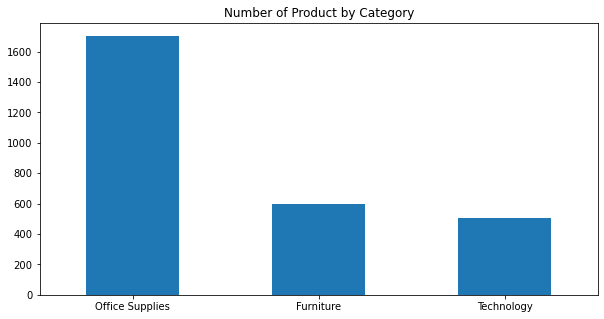

In [14]:
plt.figure(figsize=(10, 5))
east['Category'].value_counts().plot.bar(title='Number of Product by Category', rot=0)

[]

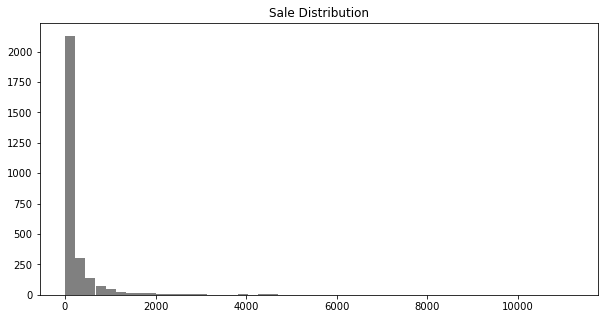

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(east['Sales'], bins=50, color='gray')
plt.title('Sale Distribution')

plt.plot()

<AxesSubplot:title={'center':'Number of transactions by quantity'}>

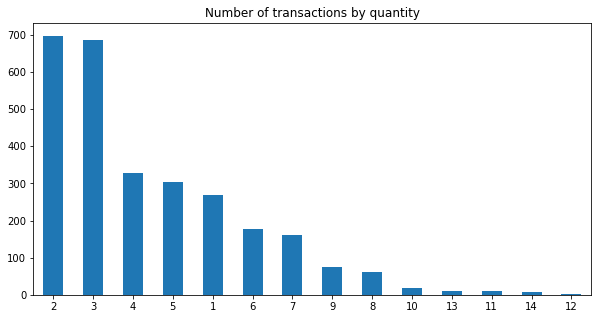

In [16]:
plt.figure(figsize=(10, 5))
east['Quantity'].value_counts().plot.bar(title='Number of transactions by quantity', rot=0)

<AxesSubplot:title={'center':'Number of transactions by ship mode'}>

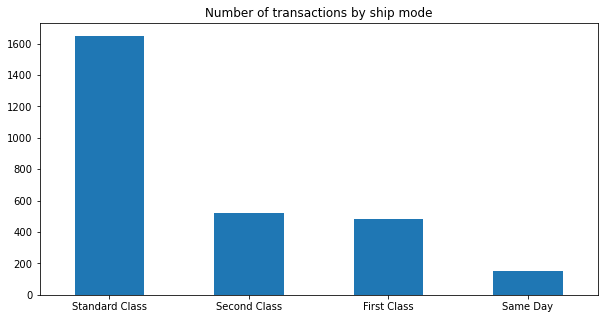

In [17]:
plt.figure(figsize=(10, 5))
east['Ship Mode'].value_counts().plot.bar(title='Number of transactions by ship mode', rot=0)

### Which category made the most sales over years?

<AxesSubplot:title={'center':'Percentage of sales by category and year'}, xlabel='Year'>

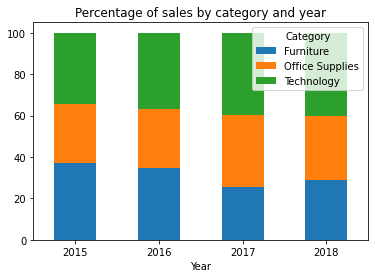

In [18]:
Category_Sales = east.groupby(['Year', 'Category']).agg({'Sales': 'sum'}).reset_index()
Category_Sales['%'] = np.round(100 * Category_Sales['Sales'] / Category_Sales.groupby('Year')['Sales'].transform('sum'), 2)
Category_Sales.drop(columns=['Sales'], inplace=True)
Category_Sales = Category_Sales.pivot(index='Year', values='%', columns='Category')
Category_Sales.plot.bar(stacked=True, title='Percentage of sales by category and year', rot=0)


**Why most sales was generated from Technology products?**

In [19]:
product = east.groupby(['Product ID', 'Product Name']).agg({'Price per unit': 'mean', 'Quantity': 'sum', 'Sales': 'sum'}).reset_index()
product['Price per unit'] = np.round(product['Price per unit'], 2)
product = product.merge(east[['Product ID', 'Category', 'Sub-Category', 'Product Name']], how='left', on=['Product ID', 'Product Name'])
product.drop_duplicates(inplace=True)
product.reset_index(inplace=True)
product.drop(columns=['index'], inplace=True)
product

,Product ID,Product Name,Price per unit,Quantity,Sales,Category,Sub-Category
0,FUR-BO-10000362,Sauder Inglewood Library Bookcases,170.98,9,1504.61,Furniture,Bookcases
1,FUR-BO-10000780,O'Sullivan Plantations 2-Door Library in Landv...,200.98,5,623.03,Furniture,Bookcases
2,FUR-BO-10001337,O'Sullivan Living Dimensions 2-Shelf Bookcases,120.98,4,483.92,Furniture,Bookcases
3,FUR-BO-10001519,O'Sullivan 3-Shelf Heavy-Duty Bookcases,58.14,7,273.24,Furniture,Bookcases
4,FUR-BO-10001608,"Hon Metal Bookcases, Black",70.98,12,681.40,Furniture,Bookcases
...,...,...,...,...,...,...,...
1426,TEC-PH-10004908,Panasonic KX TS3282W Corded phone,84.98,2,101.98,Technology,Phones
1427,TEC-PH-10004912,Cisco SPA112 2 Port Phone Adapter,54.95,3,164.84,Technology,Phones
1428,TEC-PH-10004922,RCA Visys Integrated PBX 8-Line Router,66.98,2,133.97,Technology,Phones
1429,TEC-PH-10004959,Classic Ivory Antique Telephone ZL1810,100.48,1,100.48,Technology,Phones


[Text(0.5, 1.0, 'Distribution of sales by category')]

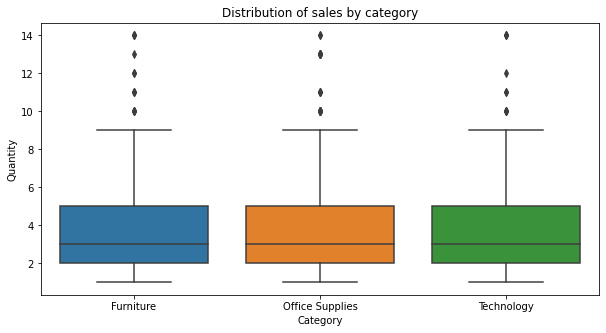

In [20]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Category', y='Quantity', data=east).set(title='Distribution of sales by category')

[Text(0.5, 1.0, 'Price per unit distribution with long interval')]

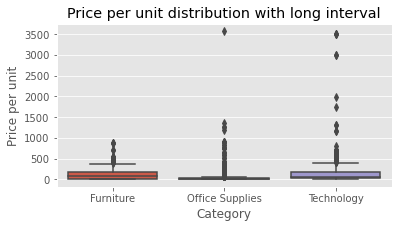

In [21]:
# Long intervals

plt.style.use('ggplot')
plt.figure(figsize=(6, 3))
sns.boxplot(x='Category', y='Price per unit', data=east).set(title='Price per unit distribution with long interval')

(0.0, 500.0)

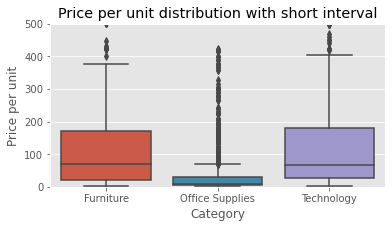

In [22]:
# east[east['Category'].isin(['Technology', 'Furniture'])]

plt.figure(figsize=(6, 3))
sns.boxplot(x='Category', y='Price per unit', data=east).set(title='Price per unit distribution with short interval')
plt.ylim([0, 500])

[Text(0.5, 1.0, 'Discount distribution by category')]

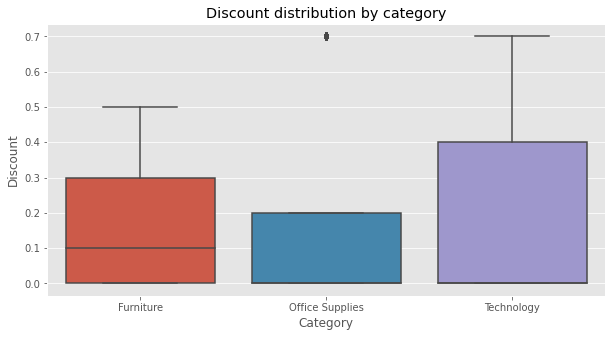

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Category', y='Discount', data=east).set(title='Discount distribution by category')

### Which products got most sales and quantity?

[Text(0.5, 1.0, 'Sales versus quantity')]

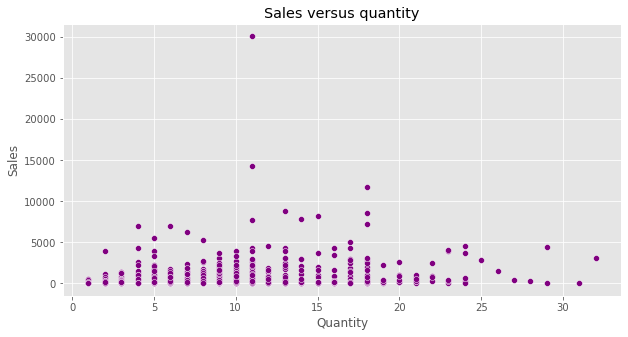

In [24]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Quantity', y='Sales', data=product, color='purple').set(title='Sales versus quantity')

In [25]:
product[['Quantity', 'Sales']].describe()

,Quantity,Sales
count,1431.000000,1431.000000
mean,7.313068,471.685681
std,4.986678,1307.042982
min,1.000000,1.240000
25%,3.000000,33.475000
50%,6.000000,104.800000
75%,10.000000,359.575000
max,32.000000,30099.890000


In [26]:
product['Q'] = product['Quantity'].apply(lambda x: 4 if (x>10)
                                             else (3 if (x>6)
                                             else (2 if (x>3)
                                             else (1))))

In [27]:
product['S'] = product['Sales'].apply(lambda x: 4 if (x>359.575)
                                          else (3 if (x>104.8)
                                          else (2 if (x>33.475)
                                          else (1))))

In [28]:
best_product = product[(product['Q'] == 4) & (product['S'] == 4)][['Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Sales', 'Q', 'S']]
best_product.reset_index(inplace=True)
best_product.drop(columns=['index'], inplace=True)
best_product

,Product ID,Category,Sub-Category,Product Name,Quantity,Sales,Q,S
0,FUR-BO-10001608,Furniture,Bookcases,"Hon Metal Bookcases, Black",12,681.40,4,4
1,FUR-BO-10002213,Furniture,Bookcases,DMI Eclipse Executive Suite Bookcases,18,7214.10,4,4
2,FUR-BO-10002545,Furniture,Bookcases,"Atlantic Metals Mobile 3-Shelf Bookcases, Cust...",14,2975.17,4,4
3,FUR-BO-10002598,Furniture,Bookcases,"Hon Metal Bookcases, Putty",15,1036.30,4,4
4,FUR-BO-10002613,Furniture,Bookcases,"Atlantic Metals Mobile 4-Shelf Bookcases, Cust...",13,2922.17,4,4
...,...,...,...,...,...,...,...,...
125,TEC-PH-10002834,Technology,Phones,Google Nexus 5,17,2843.84,4,4
126,TEC-PH-10002885,Technology,Phones,Apple iPhone 5,14,7797.95,4,4
127,TEC-PH-10003072,Technology,Phones,Panasonic KX-TG9541B DECT 6.0 Digital 2-Line E...,19,2249.84,4,4
128,TEC-PH-10004093,Technology,Phones,Panasonic Kx-TS550,14,515.08,4,4


In [29]:
best_product['Category'].value_counts()

Office Supplies    48
Furniture          46
Technology         36
Name: Category, dtype: int64

### Sale prediction in 2019

In [30]:
Sales = east.groupby(['Year', 'Month']).agg({'Sales': 'sum'}).reset_index()
Sales['Date'] = pd.to_datetime(dict(year=Sales['Year'], month=Sales['Month'], day=1))
Sales

,Year,Month,Sales,Date
0,2015,1,443.88,2015-01-01
1,2015,2,199.76,2015-02-01
2,2015,3,5943.21,2015-03-01
3,2015,4,3111.40,2015-04-01
4,2015,5,6788.72,2015-05-01
5,2015,6,11312.68,2015-06-01
6,2015,7,3568.03,2015-07-01
7,2015,8,4582.27,2015-08-01
8,2015,9,25086.98,2015-09-01
9,2015,10,8767.97,2015-10-01


In [31]:
Sales.drop(columns=['Year', 'Month'], inplace=True)
Sales.set_index('Date', inplace=True)
Sales = Sales.asfreq('MS')
Sales

,Sales
Date,
2015-01-01,443.88
2015-02-01,199.76
2015-03-01,5943.21
2015-04-01,3111.40
2015-05-01,6788.72
2015-06-01,11312.68
2015-07-01,3568.03
2015-08-01,4582.27
2015-09-01,25086.98


In [32]:
s = setup(Sales, fh=6, n_jobs=1)

,Description,Value
0,session_id,1776
1,Target,Sales
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(48, 1)"
5,Train data shape,"(42, 1)"
6,Test data shape,"(6, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


In [33]:
plot_model(plot = 'train_test_split')

In [34]:
best = compare_models(sort='MASE')

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,5198.3027,6545.7287,0.7814,0.4192,1.2465,1.2733,-0.4788,0.5067
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,5501.3527,7018.0155,0.8245,0.4346,1.2815,1.3401,-0.8637,0.0433
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,5522.2438,6373.9381,0.5872,0.5094,1.2893,1.1956,-0.3417,0.0467
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,5923.1630,6844.6030,0.6225,0.4668,1.3152,1.2174,-0.8329,0.0500
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,5565.7769,6749.0264,0.7544,0.4247,1.3231,1.2932,-0.5036,0.2167
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,5793.1999,6934.5537,0.7434,0.5018,1.3524,1.3049,-0.5658,0.1867
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,5747.6180,6957.9726,0.8215,0.4447,1.3709,1.3482,-0.6507,0.0633
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,5929.0945,7269.6326,0.8268,0.4576,1.3930,1.3942,-0.8359,0.0467
grand_means,Grand Means Forecaster,6198.3596,7124.1937,0.7102,0.5180,1.4363,1.3258,-0.7353,0.0267
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,6502.3174,7692.0584,0.7721,0.4965,1.4916,1.4185,-0.9940,0.1200


In [35]:
best

BaseCdsDtForecaster(regressor=<catboost.core.CatBoostRegressor object at 0x7fb4520d5610>,
                    sp=12, window_length=12)

In [36]:
plot_model(best, plot='forecast')

In [37]:
plot_model(finalize_model(best), plot='forecast', data_kwargs={'fh': 12})

In [38]:
predict_model(finalize_model(best), fh = 12)

,y_pred
2019-01,10112.2779
2019-02,7594.6735
2019-03,14166.6595
2019-04,16723.3578
2019-05,17064.2397
2019-06,17001.2197
2019-07,14744.5065
2019-08,14986.3774
2019-09,30808.2665
2019-10,15068.8115


In [39]:
predict_model(finalize_model(best), fh = 12).sum()

y_pred    232607.5472
dtype: float64

### Predict total customers and profit by sales

In [40]:
year_ = east.groupby(['Year']).agg({'Customer ID': 'nunique', 'Profit': 'sum', 'Sales': 'sum'}).reset_index().rename(columns={'Customer ID': 'Customer'})
year_

,Year,Customer,Profit,Sales
0,2015,228,16644.1895,128092.69
1,2016,245,20719.3430,155997.65
2,2017,300,19571.7361,179112.37
3,2018,354,32575.4314,211779.50


In [41]:
year_[['Customer', 'Sales', 'Profit']].corr()

,Customer,Sales,Profit
Customer,1.000000,0.978984,0.877594
Sales,0.978984,1.000000,0.889903
Profit,0.877594,0.889903,1.000000


**Customer prediction**

In [42]:
X = year_.iloc[:, 1].values.reshape(-1, 1)
y = year_.iloc[:, 3].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

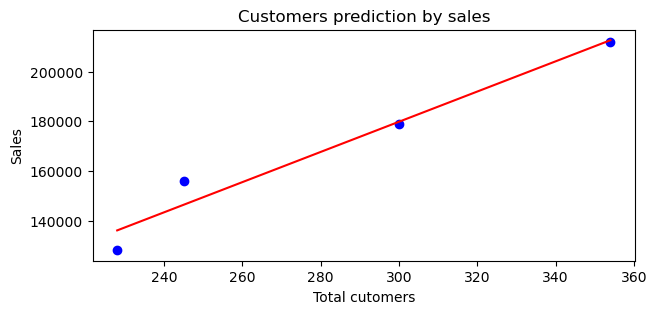

In [43]:
plt.style.use('default')

plt.figure(figsize=(7,3))
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')

plt.xlabel('Total cutomers')
plt.ylabel('Sales')
plt.title('Customers prediction by sales')

plt.show()

In [44]:
sales_2019 = 282807

new_cus = int(((sales_2019 - model.intercept_) / model.coef_)[0][0])
new_cus

469

**Profit prediction**

In [45]:
X = year_.iloc[:, 3].values.reshape(-1, 1)
y = year_.iloc[:, 2].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

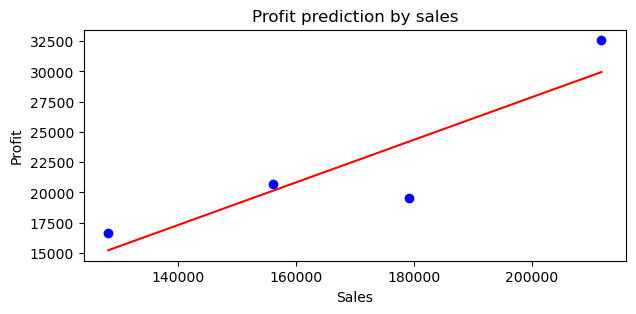

In [46]:
plt.figure(figsize=(7,3))
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')

plt.xlabel('Sales')
plt.ylabel('Profit')
plt.title('Profit prediction by sales')

plt.show()

In [47]:
sales_2019 = [[282807]]

profit_2019 = model.predict(sales_2019)[0][0]
profit_2019

42442.278633059366

## Customer Segmentation

In [48]:
customers = east.groupby('Customer ID').agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()
customers

,Customer ID,Sales,Profit
0,AA-10315,29.50,13.2826
1,AA-10375,206.72,68.9195
2,AA-10480,27.46,9.8856
3,AA-10645,1434.30,77.6417
4,AB-10060,4487.31,1468.7919
...,...,...,...
668,WB-21850,499.85,-42.2831
669,XP-21865,201.10,86.3496
670,YC-21895,3116.48,833.7633
671,YS-21880,465.18,120.9468


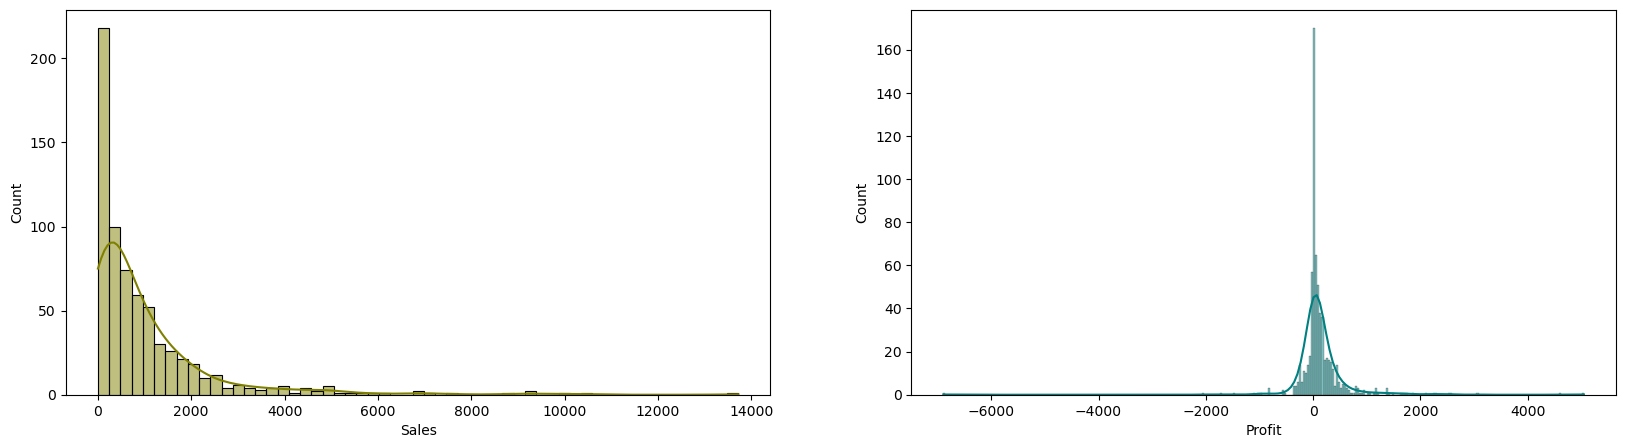

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
colors = ['olive', 'teal']

for i, feature in enumerate(['Sales', 'Profit']):
    sns.histplot(data=customers, x=feature, ax=axes[i], kde=True, color=colors[i])

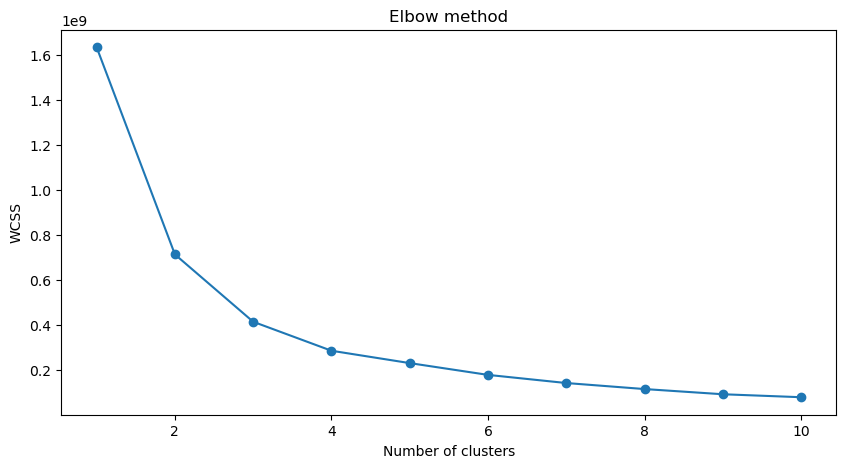

In [50]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(customers[['Sales', 'Profit']])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))    
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [51]:
model = KMeans(n_clusters=3)
model.fit(customers[['Sales', 'Profit']])

KMeans(n_clusters=3)

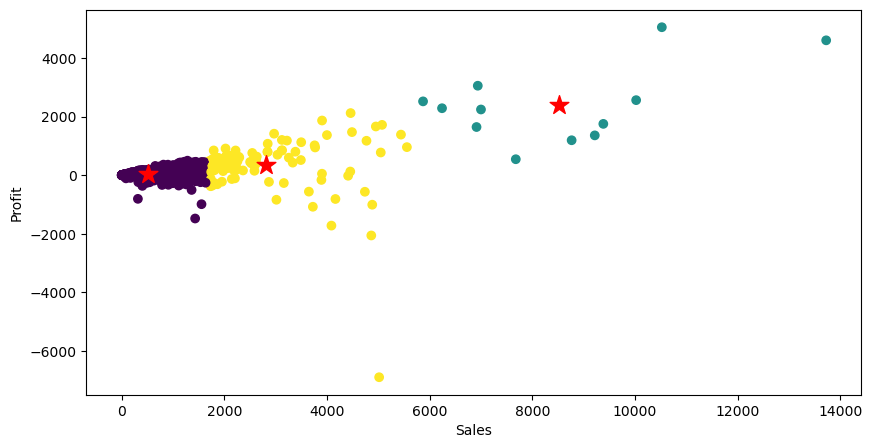

In [52]:
plt.style.use('default')
plt.figure(figsize=(10, 5))

plt.scatter(customers['Sales'], customers['Profit'], c=model.labels_)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=200, c='red', marker='*')

plt.xlabel('Sales')
plt.ylabel('Profit')

plt.show()

In [53]:
customers['Cluster'] = model.labels_

In [54]:
customers['Cluster'].value_counts()

0    558
2    103
1     12
Name: Cluster, dtype: int64

In [55]:
customers[customers['Cluster'] == 0].describe()

,Sales,Profit,Cluster
count,558.000000,558.000000,558.0
mean,507.549767,47.725112,0.0
std,454.236794,162.678731,0.0
min,0.850000,-1478.556300,0.0
25%,106.135000,1.136650,0.0
50%,395.300000,29.346000,0.0
75%,801.487500,115.772475,0.0
max,1689.350000,494.093600,0.0


In [56]:
customers[customers['Cluster'] == 1].describe()

,Sales,Profit,Cluster
count,12.000000,12.000000,12.0
mean,8522.951667,2397.953717,1.0
std,2234.915560,1325.785621,0.0
min,5871.730000,543.281900,1.0
25%,6931.667500,1570.537425,1.0
50%,8221.900000,2261.516750,1.0
75%,9542.755000,2681.518750,1.0
max,13723.470000,5045.856400,1.0


In [57]:
customers[customers['Cluster'] == 2].describe()

,Sales,Profit,Cluster
count,103.000000,103.000000,103.0
mean,2810.621553,331.113038,2.0
std,1052.906452,973.358827,0.0
min,1675.400000,-6892.374800,2.0
25%,1958.655000,152.283850,2.0
50%,2525.870000,448.546300,2.0
75%,3438.645000,726.564500,2.0
max,5557.070000,2117.590400,2.0
